# 50 Years of Music Trends

## Objective
* Analyze lyrics from billboard top 100 songs over 50 years to identify trends
* Statement: Has the sentiments of popular lyrics changed over time?

## Hypothesis
* Ha1 = the sentiments of popular lyrics has become more negative over time
* Ha2 = the sentiments of popular lyrics has become more positive over time
* Ho = no change in the sentiments of popular lyrics over time 

## Sources
* musixmatch source: https://developer.musixmatch.com/documentation/api-reference/track-lyrics-get <br/>
* musixmatch python: https://github.com/hudsonbrendon/python-musixmatch <br/>
* billboard python: https://github.com/guoguo12/billboard-charts<br/>

In [1]:
# Dependency library
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# API Calls
import billboard
import spotipy.util as util
from musixmatch import Musixmatch
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# API Keys
from musixmatch_api import api_key
from spotify_api import SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET, SPOTIPY_REDIRECT_URI, username

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# Generate a (pseudo) random list of (almost all) dates in string format to fit musixmatch parameter

date_list = []
min_year = 1968
start = datetime(min_year, 1, 1)
error_counter = 0

for i in range(50):
    try:
        # RANDOM date generation
        month_rand = str(random.randint(1,12))
        if len(month_rand) ==1:
            # PAD single digit numbers with a leading 0
            month_rand = month_rand.zfill(2)
            
        day_rand = str(random.randint(1,28))
        if len(day_rand) == 1:
            day_rand = day_rand.zfill(2)
        
        # STRINGIFY the result for the musixmatch parameter
        date_rand = str(f'{min_year}-{month_rand}-{day_rand}')
        
        # APPEND result to date_list
        date_list.append(date_rand)
        
        #INCREMENT the year
        min_year = min_year + 1
    except ValueError:
        error_counter = error_counter + 1
        
date_list

['1968-10-10',
 '1969-11-26',
 '1970-04-05',
 '1971-05-12',
 '1972-06-28',
 '1973-06-17',
 '1974-05-05',
 '1975-11-03',
 '1976-10-17',
 '1977-06-16',
 '1978-03-08',
 '1979-02-12',
 '1980-10-15',
 '1981-05-27',
 '1982-04-09',
 '1983-12-27',
 '1984-03-17',
 '1985-03-28',
 '1986-01-27',
 '1987-09-16',
 '1988-10-27',
 '1989-06-17',
 '1990-01-06',
 '1991-09-23',
 '1992-09-14',
 '1993-08-27',
 '1994-03-17',
 '1995-04-24',
 '1996-01-07',
 '1997-08-07',
 '1998-10-12',
 '1999-10-01',
 '2000-12-20',
 '2001-09-18',
 '2002-01-10',
 '2003-01-08',
 '2004-03-24',
 '2005-04-17',
 '2006-06-17',
 '2007-07-13',
 '2008-04-20',
 '2009-09-28',
 '2010-06-20',
 '2011-04-05',
 '2012-10-21',
 '2013-12-08',
 '2014-04-09',
 '2015-05-27',
 '2016-05-25',
 '2017-05-03']

In [3]:
# Return top 100 billboard songs for each date in random list generated above

billboard_list = 'hot-100'
col_names = ['Song','Artist','Date']
chart_df = pd.DataFrame(columns = col_names)

for date in date_list:
    chart_list = []
    chart = billboard.ChartData(billboard_list,date)
    for row in chart:
        
        # CLEAN and convert the billboard object
        chart_list.append(str(row).replace("'","",1))
        temp_df = pd.DataFrame(chart_list)
        temp_df = temp_df[0].str.split("' by ",expand=True)
        temp_df = temp_df.rename(columns={0:"Song",1:"Artist"})
        temp_df['Date'] = date
        
        # APPEND the temp_df in the current loop location to the chart_df
        chart_df = chart_df.append(temp_df)

# REMOVE duplicates and RESET index from the resulting dataframe        
chart_df = chart_df.drop_duplicates().reset_index(drop=True)

# PREVIEW
chart_df.head()

,Song,Artist,Date
0,Hey Jude,The Beatles,1968-10-10
1,Harper Valley P.T.A.,Jeannie C. Riley,1968-10-10
2,Fire,The Crazy World Of Arthur Brown,1968-10-10
3,Little Green Apples,O.C. Smith,1968-10-10
4,Girl Watcher,The O'Kaysions,1968-10-10


In [4]:
# SPLIT the date values in the dataframe for plotting and analysis purposes

chart_df['Year'], chart_df['Month'], chart_df['Day'] = chart_df['Date'].str.split('-').str

# PREVIEW
chart_df.head()

,Song,Artist,Date,Year,Month,Day
0,Hey Jude,The Beatles,1968-10-10,1968,10,10
1,Harper Valley P.T.A.,Jeannie C. Riley,1968-10-10,1968,10,10
2,Fire,The Crazy World Of Arthur Brown,1968-10-10,1968,10,10
3,Little Green Apples,O.C. Smith,1968-10-10,1968,10,10
4,Girl Watcher,The O'Kaysions,1968-10-10,1968,10,10


In [5]:
# Retrieve lyrics from MusixMatch API based on song and artist in above dataframe

musixmatch = Musixmatch(api_key)
lyrics_list = []
error_counter = 0

# LOOP through the data frame and use song title and artist name to search for lyrics in musixmatch
for x in range(len(chart_df)):
    
    # ERROR HANDLING in case a song queries returns 'null' from musixmatch
    try:
        # GRAB the lyrics based on location (iloc) in chart_df
        song_search = chart_df.iloc[x,0]
        artist_search = chart_df.iloc[x,1]
        lyrics = musixmatch.matcher_lyrics_get(q_artist=artist_search,
                                               q_track=song_search)['message']['body']['lyrics']['lyrics_body']
        
        # FORMATTING to truncate the nonsense at the end of the lyrics from MusixMatch
        song_length = len(lyrics)
        endpoint = len("******* This Lyrics is NOT for Commercial use *******\n(1409617829201)")
        lyrics = lyrics.replace("\n", " ")
        lyrics = str(lyrics[:song_length-endpoint])
        
        # APPEND lyrics to lyrics_list
        lyrics_list.append(lyrics)
        
    except:
        error_counter = error_counter + 1
        lyrics_list.append('MUSIXMATCH_NA')

# CREATE new column in chart_df
chart_df['Lyrics'] = lyrics_list
chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics
0,Hey Jude,The Beatles,1968-10-10,1968,10,10,"Hey Jude, don't make it bad Take a sad song an..."
1,Harper Valley P.T.A.,Jeannie C. Riley,1968-10-10,1968,10,10,I wanna tell you all the story bout the Harper...
2,Fire,The Crazy World Of Arthur Brown,1968-10-10,1968,10,10,(Originally written by Crazy World Of Arthur B...
3,Little Green Apples,O.C. Smith,1968-10-10,1968,10,10,And I wake up in the mornin' With my hair down...
4,Girl Watcher,The O'Kaysions,1968-10-10,1968,10,10,The O'kaysions Miscellaneous Girl Watcher Girl...


In [6]:
# Vader Sentiment Analysis on each song in the dataframe

# INITIALIZE a list to hold the sentiments
lyrics_sentiments = []

# ANALYZE the list
for y in range(len(lyrics_list)):
    results = analyzer.polarity_scores(chart_df.iloc[y,6])
    compound = results["compound"]
    pos = results["pos"]
    neu = results["neu"]
    neg = results["neg"]
    lyrics_sentiments.append({"Compound": compound,
                              "Positive": pos,
                              "Negative": neg,
                              "Neutral": neu})

# CREATE a dataframe of sentiment analysis that will be appended to the chart_df
lyrics_sentiments_df = pd.DataFrame(lyrics_sentiments)    
    
# APPEND new columns containing the sentiment analysis    
chart_df['Compound'] = lyrics_sentiments_df['Compound']
chart_df['Positive'] = lyrics_sentiments_df['Positive']
chart_df['Negative'] = lyrics_sentiments_df['Negative']
chart_df['Neutral'] = lyrics_sentiments_df['Neutral']

# SAVE to a .csv output
chart_df.to_csv('billboard_analysis.csv')

# VIEW resulting dataframe
chart_df

,Song,Artist,Date,Year,Month,Day,Lyrics,Compound,Positive,Negative,Neutral
0,Hey Jude,The Beatles,1968-10-10,1968,10,10,"Hey Jude, don't make it bad Take a sad song an...",0.8608,0.107,0.048,0.845
1,Harper Valley P.T.A.,Jeannie C. Riley,1968-10-10,1968,10,10,I wanna tell you all the story bout the Harper...,0.8219,0.092,0.000,0.908
2,Fire,The Crazy World Of Arthur Brown,1968-10-10,1968,10,10,(Originally written by Crazy World Of Arthur B...,-0.9713,0.046,0.291,0.663
3,Little Green Apples,O.C. Smith,1968-10-10,1968,10,10,And I wake up in the mornin' With my hair down...,0.7506,0.097,0.000,0.903
4,Girl Watcher,The O'Kaysions,1968-10-10,1968,10,10,The O'kaysions Miscellaneous Girl Watcher Girl...,0.0000,0.000,0.000,1.000
5,Midnight Confessions,The Grass Roots,1968-10-10,1968,10,10,The sound of your footsteps Telling me that yo...,0.9413,0.211,0.000,0.789
6,My Special Angel,The Vogues,1968-10-10,1968,10,10,"(Angel, angel, whoa-oh-oh-oh, whoa) (Angel, an...",0.9666,0.324,0.000,0.676
7,I've Gotta Get A Message To You,Bee Gees,1968-10-10,1968,10,10,"The preacher talked to me and he smiled Said, ...",0.0772,0.050,0.060,0.890
8,Over You,Gary Puckett And The Union Gap,1968-10-10,1968,10,10,Why am I loosin' sleep over you Relivin' preci...,-0.1880,0.090,0.132,0.778
9,Slip Away,Clarence Carter,1968-10-10,1968,10,10,What would I give for just a few moments what ...,0.9614,0.282,0.042,0.676


In [11]:
chart_group = chart_df.groupby(["Year"]).mean()
chart_group_df = pd.DataFrame(chart_group).reset_index(drop=False)
chart_group_df

,Year,Compound,Positive,Negative,Neutral
0,1968,0.296531,0.12006,0.05962,0.77038
1,1969,0.309991,0.11130,0.04947,0.78923
2,1970,0.370906,0.12099,0.05039,0.77866
3,1971,0.249470,0.09925,0.05188,0.73887
4,1972,0.242463,0.09974,0.05000,0.74026
5,1973,0.350116,0.11382,0.05983,0.72630
6,1974,0.417614,0.13346,0.05507,0.71151
7,1975,0.455439,0.14377,0.04346,0.70279
8,1976,0.390779,0.12343,0.05600,0.70054
9,1977,0.438762,0.12988,0.05643,0.70369


<function matplotlib.pyplot.show(*args, **kw)>

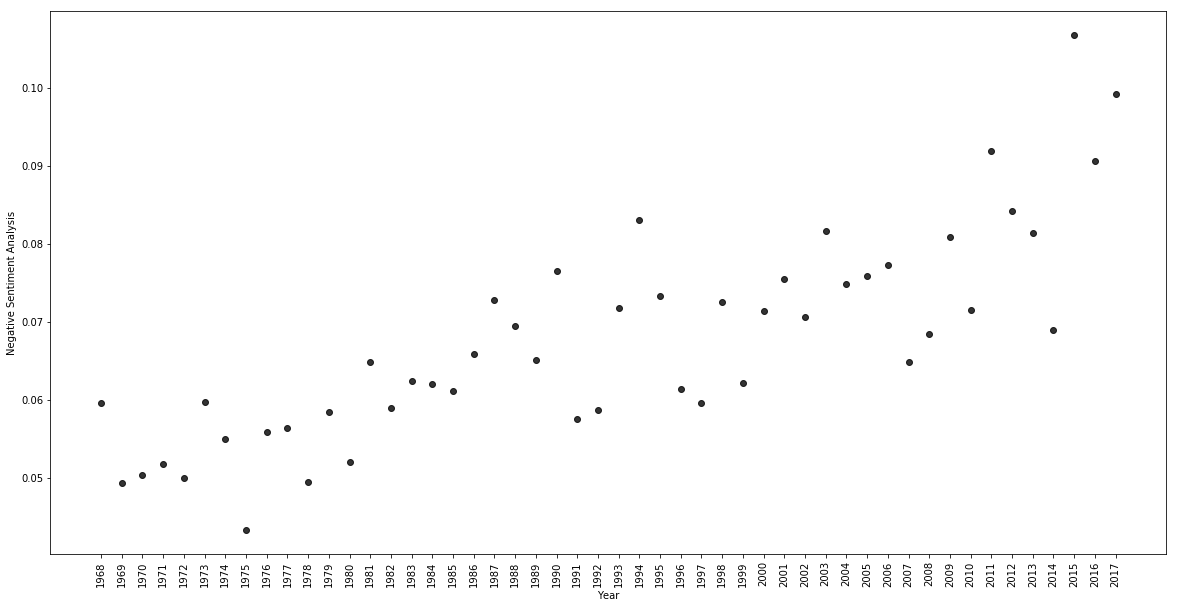

In [16]:
plt.plot(chart_group_df['Year'], chart_group_df['Negative'], marker="o", linewidth=0 ,alpha=0.8, c='k', label="Negative")
plt.rcParams["figure.figsize"] = (20,10)
plt.xticks(rotation=90)
plt.ylabel("Negative Sentiment Analysis")
plt.xlabel("Year")
plt.show